In [847]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, Normalizer 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, TweedieRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats

import itertools

## Preparation

In [890]:
path_to_dataset = Path('/home/nmramorov/Downloads/Telegram Desktop/transactions.csv')
path_to_dataset.exists()

True

In [891]:
df = pd.read_csv(path_to_dataset)
df.head()

,isFraud,TransactionDT,TransactionAmt,D1,D2,D3,card1,card2,card3,addr1,addr2,V104,V105,V106
0,0,86506,50.00,0.0,NaN,NaN,4497,514.0,150.0,420.0,87.0,0.0,0.0,0.0
1,0,86761,39.00,0.0,NaN,NaN,7875,314.0,150.0,299.0,87.0,0.0,0.0,0.0
2,0,86821,73.95,66.0,66.0,35.0,10112,360.0,150.0,264.0,87.0,0.0,0.0,0.0
3,0,87135,107.95,245.0,245.0,245.0,17359,555.0,150.0,469.0,87.0,0.0,0.0,0.0
4,0,87557,35.95,0.0,NaN,NaN,9785,343.0,150.0,485.0,87.0,0.0,0.0,0.0


In [892]:
df = df.fillna(0)
df.head()

,isFraud,TransactionDT,TransactionAmt,D1,D2,D3,card1,card2,card3,addr1,addr2,V104,V105,V106
0,0,86506,50.00,0.0,0.0,0.0,4497,514.0,150.0,420.0,87.0,0.0,0.0,0.0
1,0,86761,39.00,0.0,0.0,0.0,7875,314.0,150.0,299.0,87.0,0.0,0.0,0.0
2,0,86821,73.95,66.0,66.0,35.0,10112,360.0,150.0,264.0,87.0,0.0,0.0,0.0
3,0,87135,107.95,245.0,245.0,245.0,17359,555.0,150.0,469.0,87.0,0.0,0.0,0.0
4,0,87557,35.95,0.0,0.0,0.0,9785,343.0,150.0,485.0,87.0,0.0,0.0,0.0


In [893]:
target_feature = 'addr1'
to_remove = 'D2 V106 isFraud'.split(' ')
to_remove.append(target_feature)
X = df.drop(columns=to_remove)
to_remove.remove(target_feature)
X

,TransactionDT,TransactionAmt,D1,D3,card1,card2,card3,addr2,V104,V105
0,86506,50.000,0.0,0.0,4497,514.0,150.0,87.0,0.0,0.0
1,86761,39.000,0.0,0.0,7875,314.0,150.0,87.0,0.0,0.0
2,86821,73.950,66.0,35.0,10112,360.0,150.0,87.0,0.0,0.0
3,87135,107.950,245.0,245.0,17359,555.0,150.0,87.0,0.0,0.0
4,87557,35.950,0.0,0.0,9785,343.0,150.0,87.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
59049,15810350,92.000,3.0,4.0,2377,203.0,150.0,87.0,0.0,0.0
59050,15810372,117.000,472.0,6.0,12873,535.0,150.0,87.0,0.0,0.0
59051,15810912,73.838,0.0,0.0,5096,555.0,185.0,0.0,0.0,0.0
59052,15811007,204.970,315.0,315.0,12037,595.0,150.0,87.0,0.0,0.0


In [894]:
Y = df[target_feature]
Y.head()

0    420.0
1    299.0
2    264.0
3    469.0
4    485.0
Name: addr1, dtype: float64

Lets look at target variable:

<AxesSubplot:xlabel='addr1', ylabel='Count'>

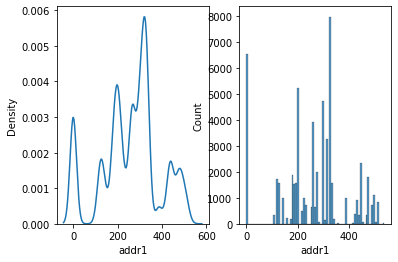

In [853]:
fig, axes = plt.subplots(1, 2)
sns.kdeplot(ax=axes[0], data=Y)
sns.histplot(ax=axes[1], data=Y)

It is clear that the target variable is continuous.

## Step 1

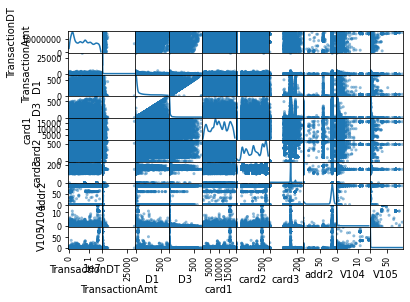

In [854]:
pd.plotting.scatter_matrix(X, diagonal="kde")
plt.show()

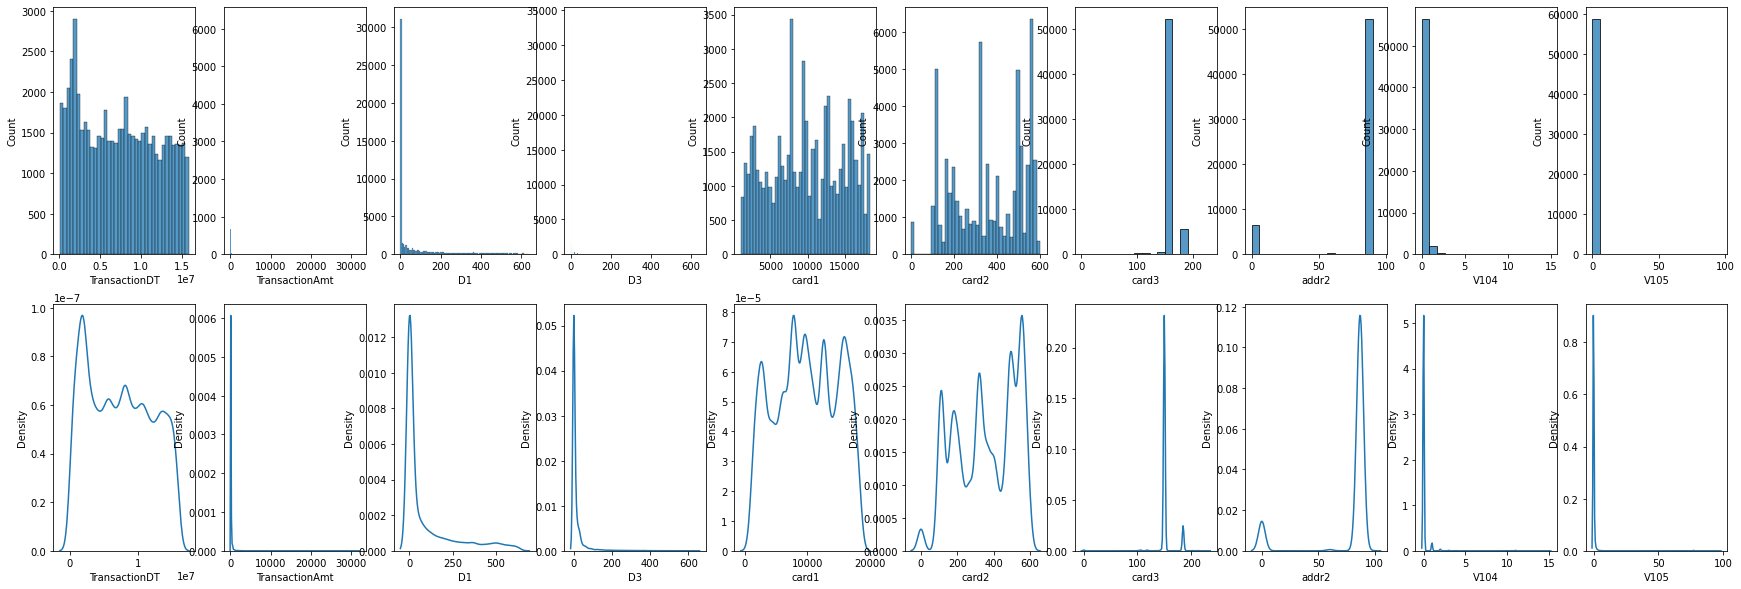

In [855]:
fig, axes = plt.subplots(2, X.shape[1], figsize=(30,10))
index_products = itertools.product(range(2), range(X.shape[1]))
iter1, iter2 = itertools.tee(X.columns)
for column, product in zip(itertools.chain(iter1, iter2), index_products):
    x, y = product
    if x == 0:
        sns.histplot(ax=axes[x][y], data=X[column])
    else:
        sns.kdeplot(ax=axes[x][y], data=X[column])

## Step 2

Mathematical Expectation for X

In [856]:
X.mean()

TransactionDT     7.346077e+06
TransactionAmt    1.358500e+02
D1                9.396270e+01
D3                1.549170e+01
card1             9.896024e+03
card2             3.571517e+02
card3             1.527605e+02
addr2             7.723782e+01
V104              8.405866e-02
V105              2.828936e-01
dtype: float64

Variance for X

In [858]:
X.cov()

,TransactionDT,TransactionAmt,D1,D3,card1,card2,card3,addr2,V104,V105
TransactionDT,2.126265e+13,1.291898e+07,5.247026e+07,5.070147e+06,3.291558e+08,-1.122346e+07,-1.816322e+06,364176.261299,214864.531858,1.229676e+06
TransactionAmt,1.291898e+07,7.227211e+04,-1.469462e+03,-1.420490e+02,-1.137873e+04,4.018355e+02,-3.040688e+02,901.700991,3.685641,-8.982726e-01
D1,5.247026e+07,-1.469462e+03,2.491432e+04,2.804796e+03,-5.948321e+03,3.417154e+02,-1.911913e+02,602.511031,-2.155891,-2.517447e+00
D3,5.070147e+06,-1.420490e+02,2.804796e+03,2.335806e+03,1.992297e+02,-5.353617e+00,-5.784886e+00,31.280333,-1.114369,-3.924566e+00
card1,3.291558e+08,-1.137873e+04,-5.948321e+03,1.992297e+02,2.388950e+07,8.037757e+03,-2.468680e+02,652.022017,158.302011,9.306515e+02
card2,-1.122346e+07,4.018355e+02,3.417154e+02,-5.353617e+00,8.037757e+03,2.646909e+04,1.845665e+02,-244.417931,4.156211,2.030131e+01
card3,-1.816322e+06,-3.040688e+02,-1.911913e+02,-5.784886e+00,-2.468680e+02,1.845665e+02,1.874164e+02,-235.841127,-0.185748,-8.227943e-01
addr2,3.641763e+05,9.017010e+02,6.025110e+02,3.128033e+01,6.520220e+02,-2.444179e+02,-2.358411e+02,745.974025,0.598233,2.313922e+00
V104,2.148645e+05,3.685641e+00,-2.155891e+00,-1.114369e+00,1.583020e+02,4.156211e+00,-1.857482e-01,0.598233,0.412523,1.823713e+00
V105,1.229676e+06,-8.982726e-01,-2.517447e+00,-3.924566e+00,9.306515e+02,2.030131e+01,-8.227943e-01,2.313922,1.823713,1.178599e+01


<AxesSubplot:>

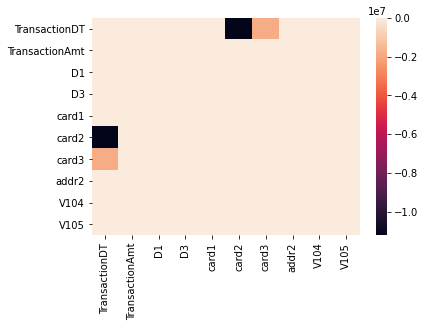

In [861]:
sns.heatmap(X.cov(), vmax=1., square=False)

## Step 3

In [862]:
uniques = Y.unique()
data = {}
groups = {}

to_remove.append(target_feature)
for unique in uniques:
    classdata = df[df[target_feature] == unique]
    classdata = classdata.drop(columns=to_remove)
    groups[unique] = classdata.copy().to_numpy()
    data[f'card1={unique} ME'] = classdata.apply(np.mean).to_numpy()
    data[f'card1={unique} variance'] = classdata.apply(np.std).to_numpy()

to_remove.remove(target_feature)
frame = pd.DataFrame(data=data, index=X.columns).T
frame

,TransactionDT,TransactionAmt,D1,D3,card1,card2,card3,addr2,V104,V105
card1=420.0 ME,7.483336e+06,160.242473,98.201613,15.551075,9605.266129,385.497312,149.553763,87.0,0.051075,0.080645
card1=420.0 variance,4.902472e+06,312.543341,163.704641,50.029884,4493.074370,170.169800,7.808516,0.0,0.274496,0.342275
card1=299.0 ME,7.069459e+06,181.254001,88.186950,15.495385,10997.614080,358.287830,149.801030,87.0,0.068899,0.107963
card1=299.0 variance,4.654484e+06,270.553195,157.427577,48.121998,5334.333315,166.661537,5.654094,0.0,0.353100,0.561843
card1=264.0 ME,7.403434e+06,151.107986,101.216500,15.292852,10166.049449,344.296695,149.645657,87.0,0.058673,0.128363
...,...,...,...,...,...,...,...,...,...,...
card1=215.0 variance,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
card1=303.0 ME,1.381619e+07,330.000000,65.000000,65.000000,2803.000000,100.000000,150.000000,40.0,0.000000,0.000000
card1=303.0 variance,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
card1=160.0 ME,1.578622e+07,161.000000,0.000000,0.000000,17188.000000,321.000000,150.000000,87.0,0.000000,0.000000


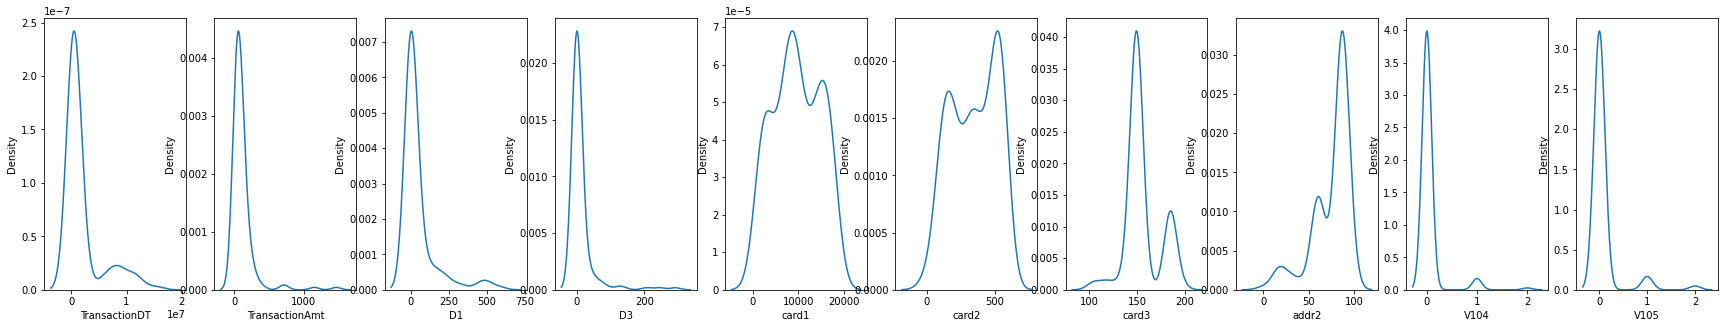

In [863]:
fig, axes = plt.subplots(1, X.shape[1], figsize=(30,5))
for index, feature in enumerate(X.columns):
    feature_data = {key: value[0][index] for key, value in groups.items()}
    sns.kdeplot(ax=axes[index], data=feature_data)
    axes[index].set_xlabel(feature)

## Step 4

We need combinations to produce each pair of features

In [864]:
pairs = itertools.combinations(X.columns, 2)
statistics_data = {pair: {} for pair in pairs}


def count_confidence_interval(fst, snd):
    r, p = stats.pearsonr(fst, snd)
    r_z = np.arctanh(r) # matches Fisher transform
    # Corresponding standard deviation
    se = 1 / np.sqrt(fst.size - 3)
    alpha = 0.05
    z = stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    return lo_z, hi_z


for pair, data in statistics_data.items():
    alpha = 0.05
    column1, column2 = pair
    data['pair correlation'], p_value = stats.pearsonr(X[column1], X[column2])
    lower, higher = count_confidence_interval(X[column1], X[column2])
    data['lower confidence interval'] = f'{lower:.6f}' 
    data['higher confidence interval'] = f'{higher:.6f}'
    data['significance level'] = f'{p_value:.6f}'
    data['is_significant'] = True if p_value >= alpha else False
    
statistics_df = pd.DataFrame(data=statistics_data)
statistics_df = statistics_df.T
statistics_df

pair correlation lower confidence interval  \
TransactionDT  TransactionAmt         0.010422                  0.002356   
               D1                     0.072091                  0.064151   
               D3                     0.022751                  0.014689   
               card1                  0.014605                  0.006540   
               card2                 -0.014961                 -0.023027   
               card3                 -0.028773                 -0.036846   
               addr2                  0.002892                 -0.005174   
               V104                   0.072549                  0.064611   
               V105                   0.077678                  0.069769   
TransactionAmt D1                     -0.03463                 -0.042709   
               D3                    -0.010933                 -0.018999   
               card1                  -0.00866                 -0.016726   
               card2                  0.009187                  0.001122   
               card3                  -0.08262                 -0.090874   
               addr2                  0.122805                  0.115362   
               V104                   0.021345                  0.013283   
               V105                  -0.000973                 -0.009039   
D1             D3                      0.36767                  0.377661   
               card1                  -0.00771                 -0.015776   
               card2                  0.013307                  0.005242   
               card3                 -0.088479                 -0.096776   
               addr2                  0.139759                  0.132614   
               V104                  -0.021266                 -0.029334   
               V105                  -0.004646                 -0.012711   
D3             card1                  0.000843                 -0.007222   
               card2                 -0.000681                 -0.008746   
               card3                 -0.008743                 -0.016809   
               addr2                  0.023697                  0.015636   
               V104                  -0.035899                 -0.043980   
               V105                  -0.023653                 -0.031723   
card1          card2                  0.010108                  0.002043   
               card3                 -0.003689                 -0.011755   
               addr2                  0.004884                 -0.003181   
               V104                   0.050426                  0.042404   
               V105                   0.055463                  0.047454   
card2          card3                  0.082867                  0.074992   
               addr2                 -0.055005                 -0.063126   
               V104                   0.039774                  0.031730   
               V105                   0.036347                  0.028298   
card3          addr2                 -0.630745                 -0.750718   
               V104                  -0.021125                 -0.029194   
               V105                  -0.017507                 -0.025574   
addr2          V104                   0.034102                  0.026050   
               V105                   0.024678                  0.016617   
V104           V105                   0.827083                  1.170768   

                              higher confidence interval significance level  \
TransactionDT  TransactionAmt                   0.018488           0.011323   
               D1                               0.080282           0.000000   
               D3                               0.030820           0.000000   
               card1                            0.022671           0.000386   
               card2                           -0.006896           0.000277   
               card3                           -0.020715   

In [865]:
significant_features = pd.DataFrame(data=statistics_df[statistics_df['is_significant'] == True])
significant_features

pair correlation lower confidence interval  \
TransactionDT  addr2         0.002892                 -0.005174   
TransactionAmt V105         -0.000973                 -0.009039   
D1             card1         -0.00771                 -0.015776   
               V105         -0.004646                 -0.012711   
D3             card1         0.000843                 -0.007222   
               card2        -0.000681                 -0.008746   
card1          card3        -0.003689                 -0.011755   
               addr2         0.004884                 -0.003181   

                     higher confidence interval significance level  \
TransactionDT  addr2                   0.010957           0.482255   
TransactionAmt V105                    0.007092           0.813034   
D1             card1                   0.000355           0.060979   
               V105                    0.003420           0.258923   
D3             card1                   0.008909           0.837611   
               card2                   0.007385           0.868587   
card1          card3                   0.004376           0.369959   
               addr2                   0.012950           0.235266   

                     is_significant  
TransactionDT  addr2           True  
TransactionAmt V105            True  
D1             card1           True  
               V105            True  
D3             card1           True  
               card2           True  
card1          card3           True  
               addr2           True

In [866]:
significant_features_with_positive_corr = pd.DataFrame(data=significant_features[significant_features['pair correlation'] > 0])
significant_features_with_positive_corr

,,pair correlation,lower confidence interval,higher confidence interval,significance level,is_significant
TransactionDT,addr2,0.002892,-0.005174,0.010957,0.482255,True
D3,card1,0.000843,-0.007222,0.008909,0.837611,True
card1,addr2,0.004884,-0.003181,0.012950,0.235266,True


<AxesSubplot:>

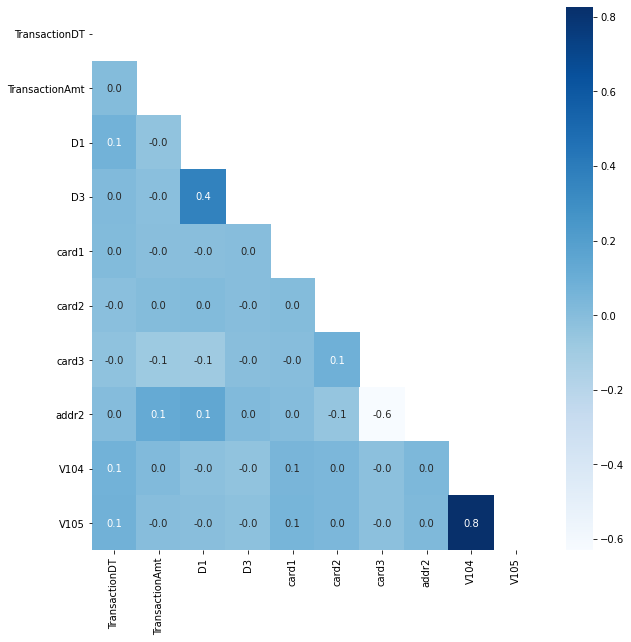

In [895]:
# Building a correlation matrix of features
features = list(X.columns)
data = df[features]
corrmat = data.corr()
mask = np.zeros_like(corrmat, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corrmat, mask = mask, annot=True, fmt= '.1f', ax = ax, cmap = 'Blues')

## Step 5

Lets estimate the multivariate correlation of target variable with predictors

In [896]:
correlations = {}

for column in X.columns:
    corr, _ = stats.pearsonr(Y, X[column])
    correlations[column] = corr
    
df = pd.DataFrame(correlations, index=['Correlation with target'])
df

,TransactionDT,TransactionAmt,D1,D3,card1,card2,card3,addr2,V104,V105
Correlation with target,0.002169,0.077173,0.098369,0.015099,0.017143,-0.019797,-0.431896,0.68615,0.032813,0.026971


Count multivariate correlation coefficient using [formula](https://en.wikipedia.org/wiki/Multiple_correlation#:~:text=In%20statistics%2C%20the%20coefficient%20of,linearly%20from%20the%20predictive%20variables.):

In [897]:
corr = np.array(list(correlations.values()))
multivariate_corr = np.sqrt(corr.dot(np.linalg.inv(corrmat)).dot(corr.T))
print(f'Multivariate correlation is {multivariate_corr:.5f}')

Multivariate correlation is 0.68662


## Step 6

Lets build a regression model like we usually do. First, our dataset is split on train and test samples.

In [898]:
X_new = X[['addr2', 'D1', 'TransactionAmt']]
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.25, random_state=42)

Next lets train a regression model

In [899]:
reg = LinearRegression(normalize=True)

reg.fit(X_train, y_train)

LinearRegression(normalize=True)

Then lets visualize the results:

<AxesSubplot:ylabel='addr1'>

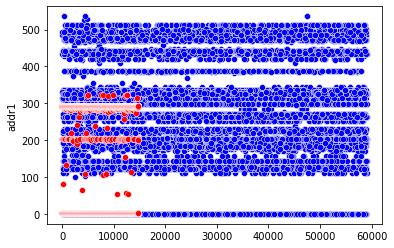

In [900]:
y_pred = reg.predict(X_test)
y_pred_all = reg.predict(X_new)

sns.scatterplot(data=y_test, color='b')
sns.scatterplot(data=y_pred, color='r')

Посмотрим на метрики:

In [901]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.5f}')
print(f'Mean Square Error: {mse:.5f}')

Mean Absolute Error: 72.20442
Mean Square Error: 9290.20985


In [902]:
scaler = StandardScaler()
X_new_enhanced = pd.DataFrame(scaler.fit_transform(X))
scaler = StandardScaler()
Y_new = pd.DataFrame(scaler.fit_transform(np.array(Y).reshape((-1, 1))))

X_train, X_test, y_train, y_test = train_test_split(X_new_enhanced, Y_new, test_size=0.25, random_state=42)

poly = PolynomialFeatures(2)
X_train_new = poly.fit_transform(X_train)
poly = PolynomialFeatures(2)
X_test_new = poly.fit_transform(X_test)
reg = LinearRegression()
reg.fit(X_train_new, y_train)
y_pred_poly = reg.predict(X_test_new)
X_new_poly = poly.fit_transform(X_new_enhanced)
y_pred_poly_all = reg.predict(X_new_poly)

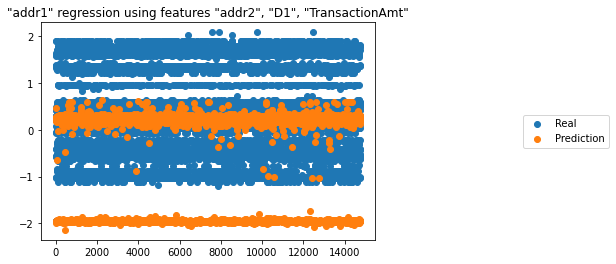

In [903]:
plt.scatter([i for i in range(len(X_test_new))], y_test, label = u'Real')
plt.scatter([i for i in range(len(X_test_new))], y_pred_poly, label = u'Prediction')
plt.title(f'"{target_feature}" regression using features "addr2", "D1", "TransactionAmt"')
plt.legend(loc="center right",borderaxespad=0.1, bbox_to_anchor=(1.7, 0.5))

In [904]:
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
print('Mean absolute error with Polynomial model = ', mae_poly)
print('Mean squared error with Polynomial model = ', mse_poly)

Mean absolute error with Polynomial model =  0.5424005922464624
Mean squared error with Polynomial model =  0.5244267003466606


## Step 7

Lets plot the distribution of residuals

<AxesSubplot:ylabel='Count'>

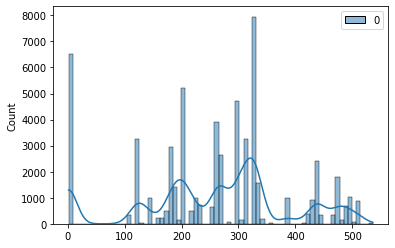

In [905]:
residuals = Y.to_numpy().reshape((-1, 1)) - y_pred_poly_all
sns.histplot(residuals, kde=True)

Lets see normality of residuals

Text(0, 0.5, 'Residual distribution')

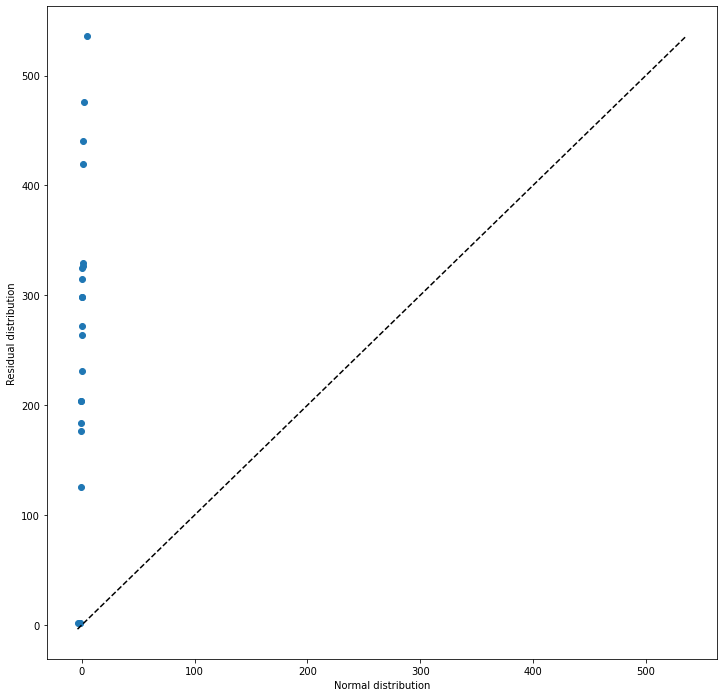

In [906]:
percs = np.linspace(0, 100, 21)
norms = np.random.normal(size=Y.shape[0])
qn_first = np.percentile(norms, percs)
qn_second = np.percentile(residuals , percs)
plt.figure(figsize=(12, 12))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")

plt.xlabel(u'Normal distribution')
plt.ylabel(u'Residual distribution')

In [910]:
residuals_me = np.mean(residuals)
residuals_std = np.std(residuals)
print(f'Residual ME: {residuals_me:.3f}\nResidual standard deviation: {residuals_std:.3f}')

Residual ME: 259.110
Residual standard deviation: 131.974


Lets count determination coefficient on the test samples

In [908]:
r2 = r2_score(y_test, y_pred_poly)

In [909]:
r2

0.47635242497268127